In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from tqdm import tqdm

In [2]:
songs = pd.read_csv('tracks_features.csv')

In [3]:
songs.head()

id                   name                      album  \
0  7lmeHLHBe4nmXzuXc0HDjk                Testify  The Battle Of Los Angeles   
1  1wsRitfRRtWyEapl0q22o8        Guerrilla Radio  The Battle Of Los Angeles   
2  1hR0fIFK2qRG3f3RF70pb7       Calm Like a Bomb  The Battle Of Los Angeles   
3  2lbASgTSoDO7MTuLAXlTW0              Mic Check  The Battle Of Los Angeles   
4  1MQTmpYOZ6fcMQc56Hdo7T  Sleep Now In the Fire  The Battle Of Los Angeles   

                 album_id                       artists  \
0  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
1  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
2  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
3  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   
4  2eia0myWFgoHuttJytCxgX  ['Rage Against The Machine']   

                   artist_ids  track_number  disc_number  explicit  \
0  ['2d0hyoQ5ynDBnkvAbJKORj']             1            1     False   
1  ['2d0hyoQ5ynDBnkvAbJKORj']             2            1      True   
2  ['2d0hyoQ5ynDBnkvAbJKORj']             3            1     False   
3  ['2d0hyoQ5ynDBnkvAbJKORj']             4            1      True   
4  ['2d0hyoQ5ynDBnkvAbJKORj']             5            1     False   

   danceability  ...  speechiness  acousticness  instrumentalness  liveness  \
0         0.470  ...       0.0727       0.02610          0.000011    0.3560   
1         0.599  ...       0.1880       0.01290          0.000071    0.1550   
2         0.315  ...       0.4830       0.02340          0.000002    0.1220   
3         0.440  ...       0.2370       0.16300          0.000004    0.1210   
4         0.426  ...       0.0701       0.00162          0.105000    0.0789   

   valence    tempo  duration_ms  time_signature  year  release_date  
0    0.503  117.906       210133             4.0  1999    1999-11-02  
1    0.489  103.680       206200             4.0  1999    1999-11-02  
2    0.370  149.749       298893             4.0  1999    1999-11-02  
3    0.574   96.752       213640             4.0  1999    1999-11-02  
4    0.539  127.059       205600             4.0  1999    1999-11-02  

[5 rows x 24 columns]

In [4]:
songs = songs.drop(['id', 'album_id', 'artist_ids'], axis=1)

In [5]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   name              1204022 non-null  object 
 1   album             1204014 non-null  object 
 2   artists           1204025 non-null  object 
 3   track_number      1204025 non-null  int64  
 4   disc_number       1204025 non-null  int64  
 5   explicit          1204025 non-null  bool   
 6   danceability      1204025 non-null  float64
 7   energy            1204025 non-null  float64
 8   key               1204025 non-null  int64  
 9   loudness          1204025 non-null  float64
 10  mode              1204025 non-null  int64  
 11  speechiness       1204025 non-null  float64
 12  acousticness      1204025 non-null  float64
 13  instrumentalness  1204025 non-null  float64
 14  liveness          1204025 non-null  float64
 15  valence           1204025 non-null  float64
 16  

In [6]:
songs.isnull().sum()

name                 3
album               11
artists              0
track_number         0
disc_number          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
year                 0
release_date         0
dtype: int64

In [7]:
songs.describe()

track_number   disc_number  danceability        energy           key  \
count  1.204025e+06  1.204025e+06  1.204025e+06  1.204025e+06  1.204025e+06   
mean   7.656352e+00  1.055906e+00  4.930565e-01  5.095363e-01  5.194151e+00   
std    5.994977e+00  2.953752e-01  1.896694e-01  2.946839e-01  3.536731e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.000000e+00  1.000000e+00  3.560000e-01  2.520000e-01  2.000000e+00   
50%    7.000000e+00  1.000000e+00  5.010000e-01  5.240000e-01  5.000000e+00   
75%    1.000000e+01  1.000000e+00  6.330000e-01  7.660000e-01  8.000000e+00   
max    5.000000e+01  1.300000e+01  1.000000e+00  1.000000e+00  1.100000e+01   

           loudness          mode   speechiness  acousticness  \
count  1.204025e+06  1.204025e+06  1.204025e+06  1.204025e+06   
mean  -1.180870e+01  6.714595e-01  8.438219e-02  4.467511e-01   
std    6.982132e+00  4.696827e-01  1.159914e-01  3.852014e-01   
min   -6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%   -1.525400e+01  0.000000e+00  3.510000e-02  3.760000e-02   
50%   -9.791000e+00  1.000000e+00  4.460000e-02  3.890000e-01   
75%   -6.717000e+00  1.000000e+00  7.230000e-02  8.610000e-01   
max    7.234000e+00  1.000000e+00  9.690000e-01  9.960000e-01   

       instrumentalness      liveness       valence         tempo  \
count      1.204025e+06  1.204025e+06  1.204025e+06  1.204025e+06   
mean       2.828605e-01  2.015994e-01  4.279866e-01  1.176344e+02   
std        3.762844e-01  1.804591e-01  2.704846e-01  3.093705e+01   
min        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        7.600000e-06  9.680000e-02  1.910000e-01  9.405400e+01   
50%        8.080000e-03  1.250000e-01  4.030000e-01  1.167260e+02   
75%        7.190000e-01  2.450000e-01  6.440000e-01  1.370460e+02   
max        1.000000e+00  1.000000e+00  1.000000e+00  2.489340e+02   

        duration_ms  time_signature          year  
count  1.204025e+06    1.204025e+06  1.204025e+06  
mean   2.488399e+05    3.832494e+00  2.007328e+03  
std    1.622104e+05    5.611826e-01  1.210117e+01  
min    1.000000e+03    0.000000e+00  0.000000e+00  
25%    1.740900e+05    4.000000e+00  2.002000e+03  
50%    2.243390e+05    4.000000e+00  2.009000e+03  
75%    2.858400e+05    4.000000e+00  2.015000e+03  
max    6.061090e+06    5.000000e+00  2.020000e+03

In [8]:
# Filter for valid years (e.g., between 1950 and 2024)
songs = songs[(songs['year'] >= 1960) & (songs['year'] <= 2024)]

In [9]:
songs = songs.dropna()
songs.isnull().sum()

name                0
album               0
artists             0
track_number        0
disc_number         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
year                0
release_date        0
dtype: int64

In [10]:
print("\nUnique Values for Categorical Columns:")
categorical_columns = songs.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    unique_count = songs[col].nunique()
    print(f"Column: {col}, Unique Values: {unique_count}")


Unique Values for Categorical Columns:
Column: name, Unique Values: 848213
Column: album, Unique Values: 105890
Column: artists, Unique Values: 164287
Column: release_date, Unique Values: 10478



Correlation Matrix:


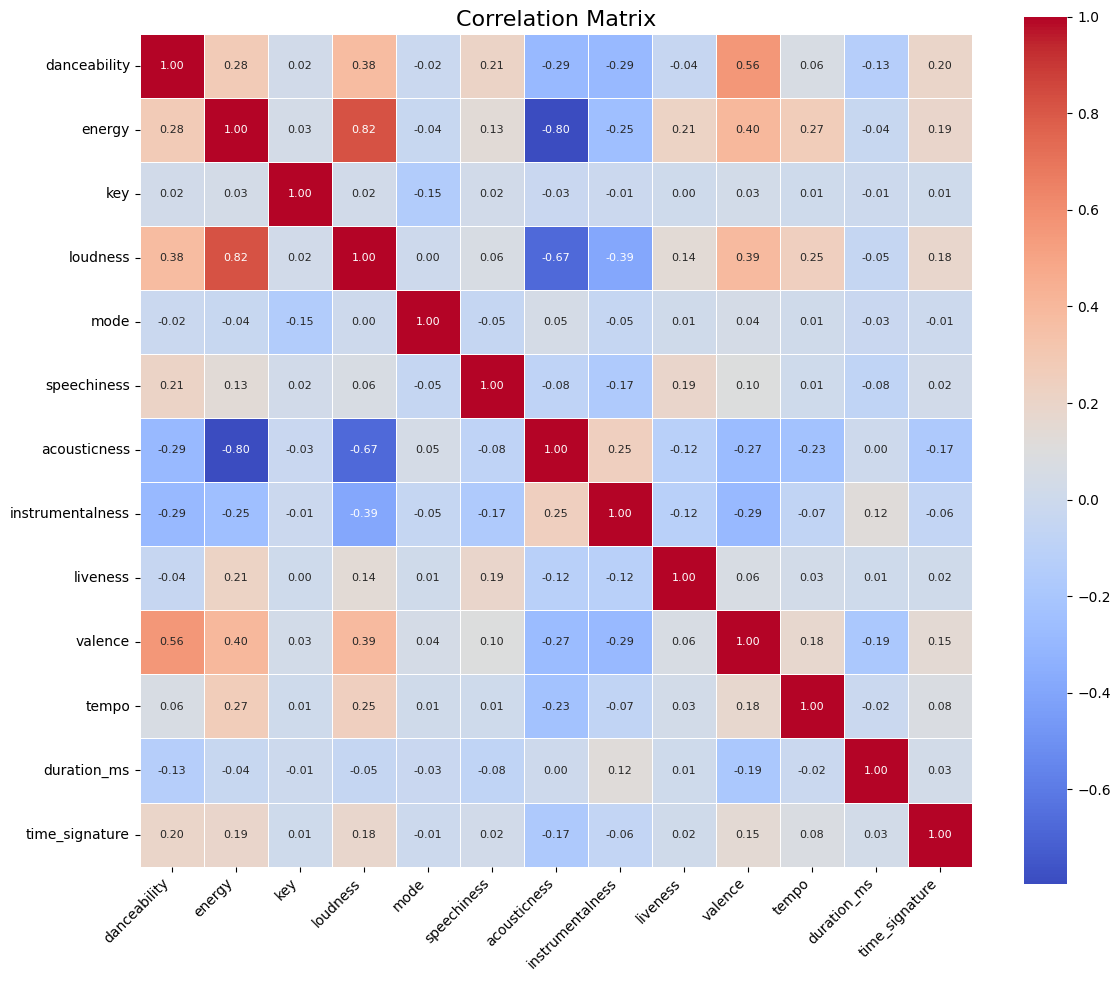

In [11]:
numeric_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'
]

if len(numeric_columns) > 1:
    print("\nCorrelation Matrix:")
    correlation_matrix = songs[numeric_columns].corr()
    
    plt.figure(figsize=(12, 10))  # Increase the figure size for better readability
    sns.heatmap(
        correlation_matrix,
        annot=True,         # Display correlation values
        fmt=".2f",          # Format values to 2 decimal places
        cmap="coolwarm",    # Use a diverging color palette
        cbar=True,          # Show color bar
        square=True,        # Keep cells square
        linewidths=0.5,     # Add space between cells
        annot_kws={"size": 8}  # Reduce annotation font size
    )
    plt.title("Correlation Matrix", fontsize=16)  # Increase title font size
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
    plt.yticks(fontsize=10)  # Adjust y-axis label font size
    plt.tight_layout()  # Automatically adjust spacing to avoid clipping
    plt.show()

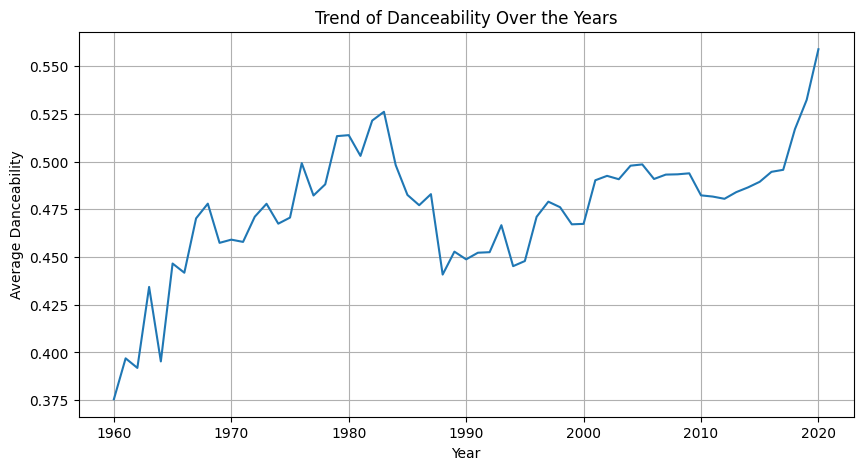

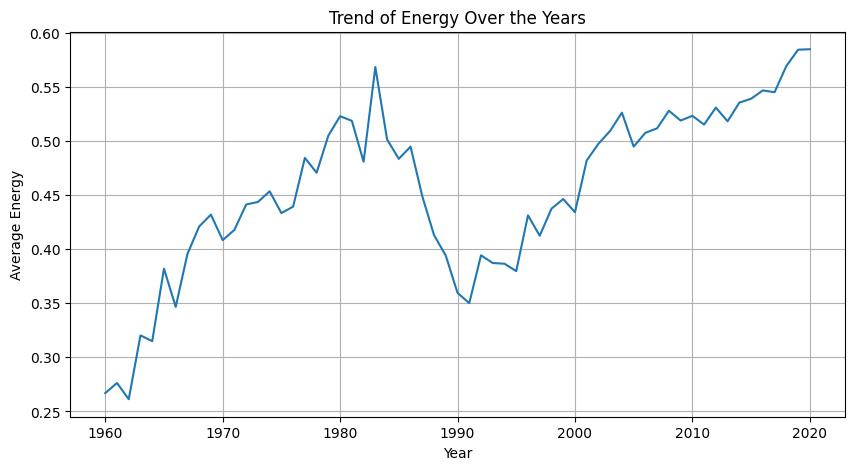

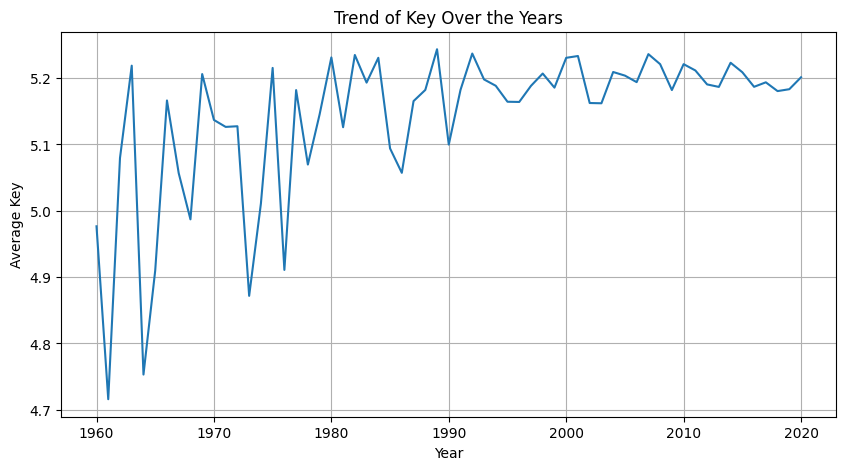

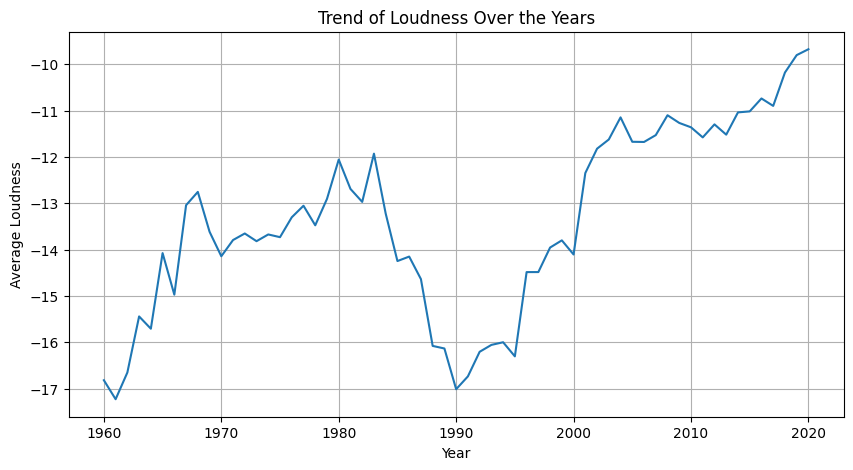

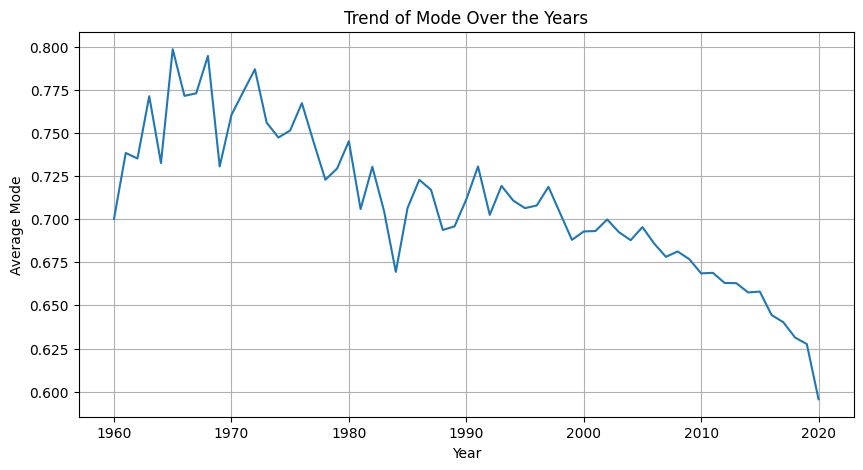

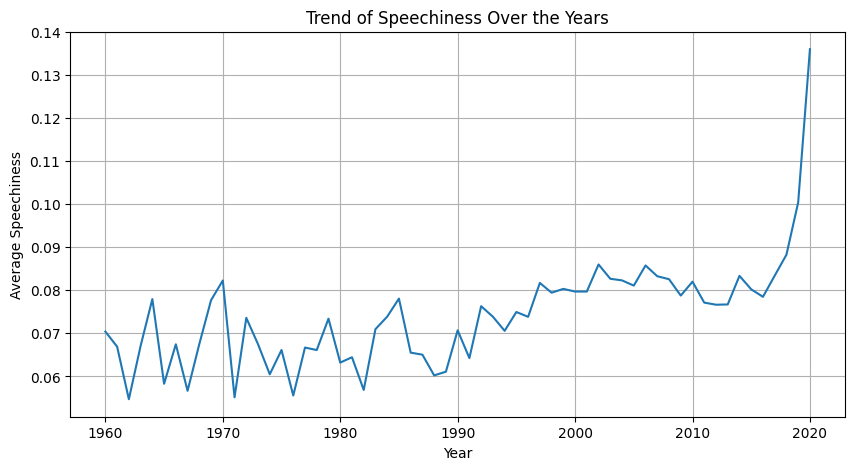

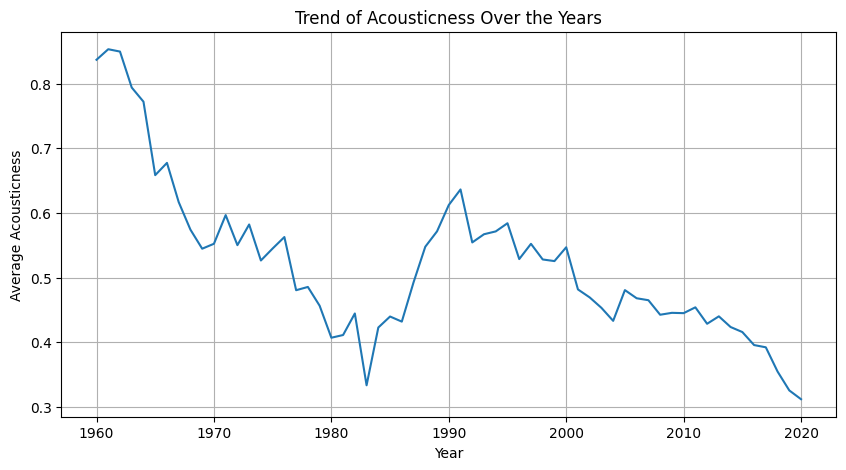

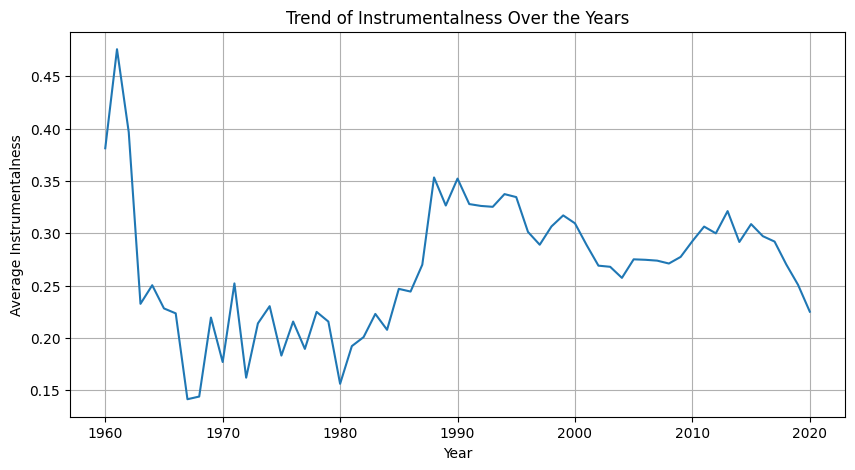

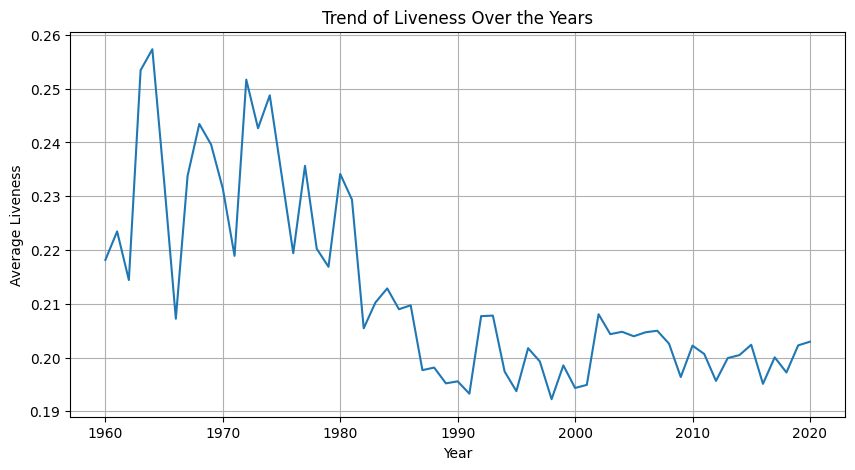

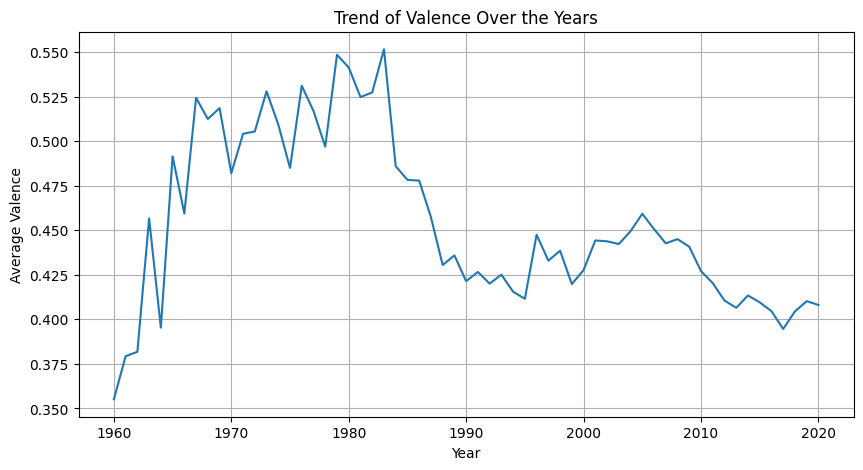

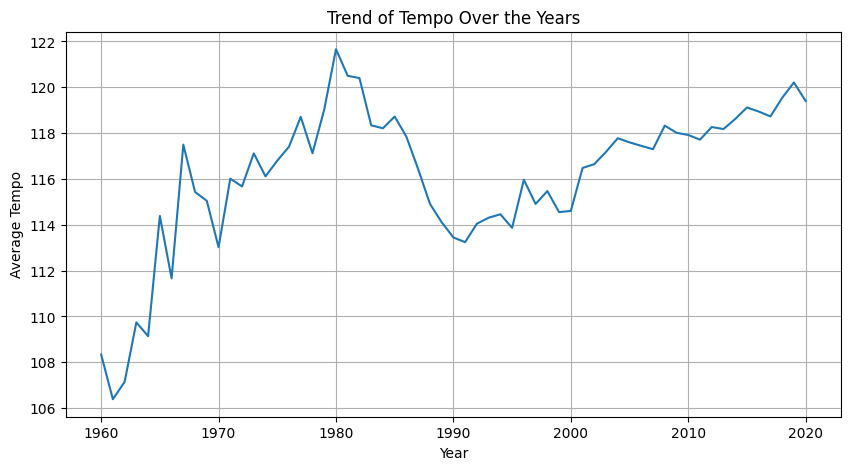

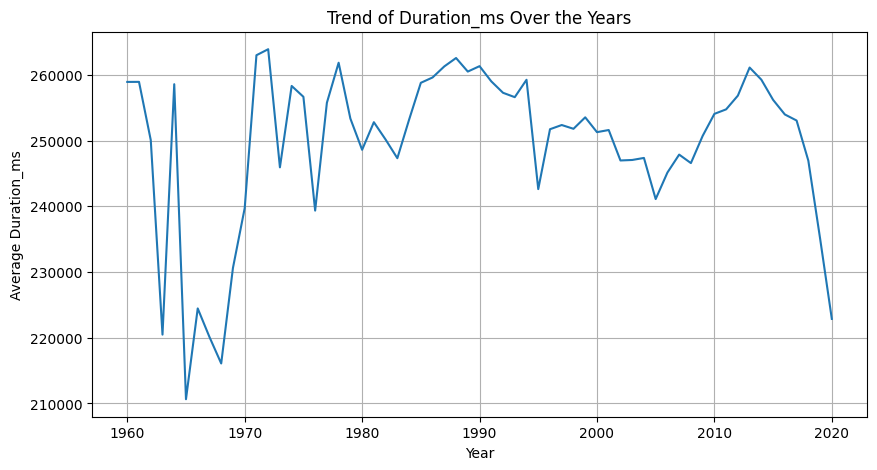

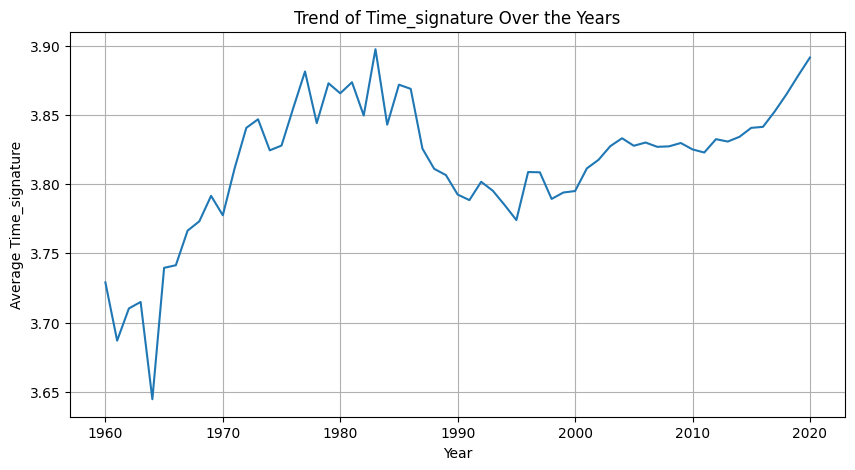

In [12]:
# Analyze trends of numeric features over the years
numeric_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'
]

# Group by year and calculate the mean for numeric columns
yearly_trends = songs.groupby('year')[numeric_columns].mean()

# Plot each numeric column as a separate graph
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=yearly_trends.index, y=yearly_trends[column])
    plt.title(f"Trend of {column.capitalize()} Over the Years")
    plt.xlabel("Year")
    plt.ylabel(f"Average {column.capitalize()}")
    plt.grid(visible=True)
    plt.show()

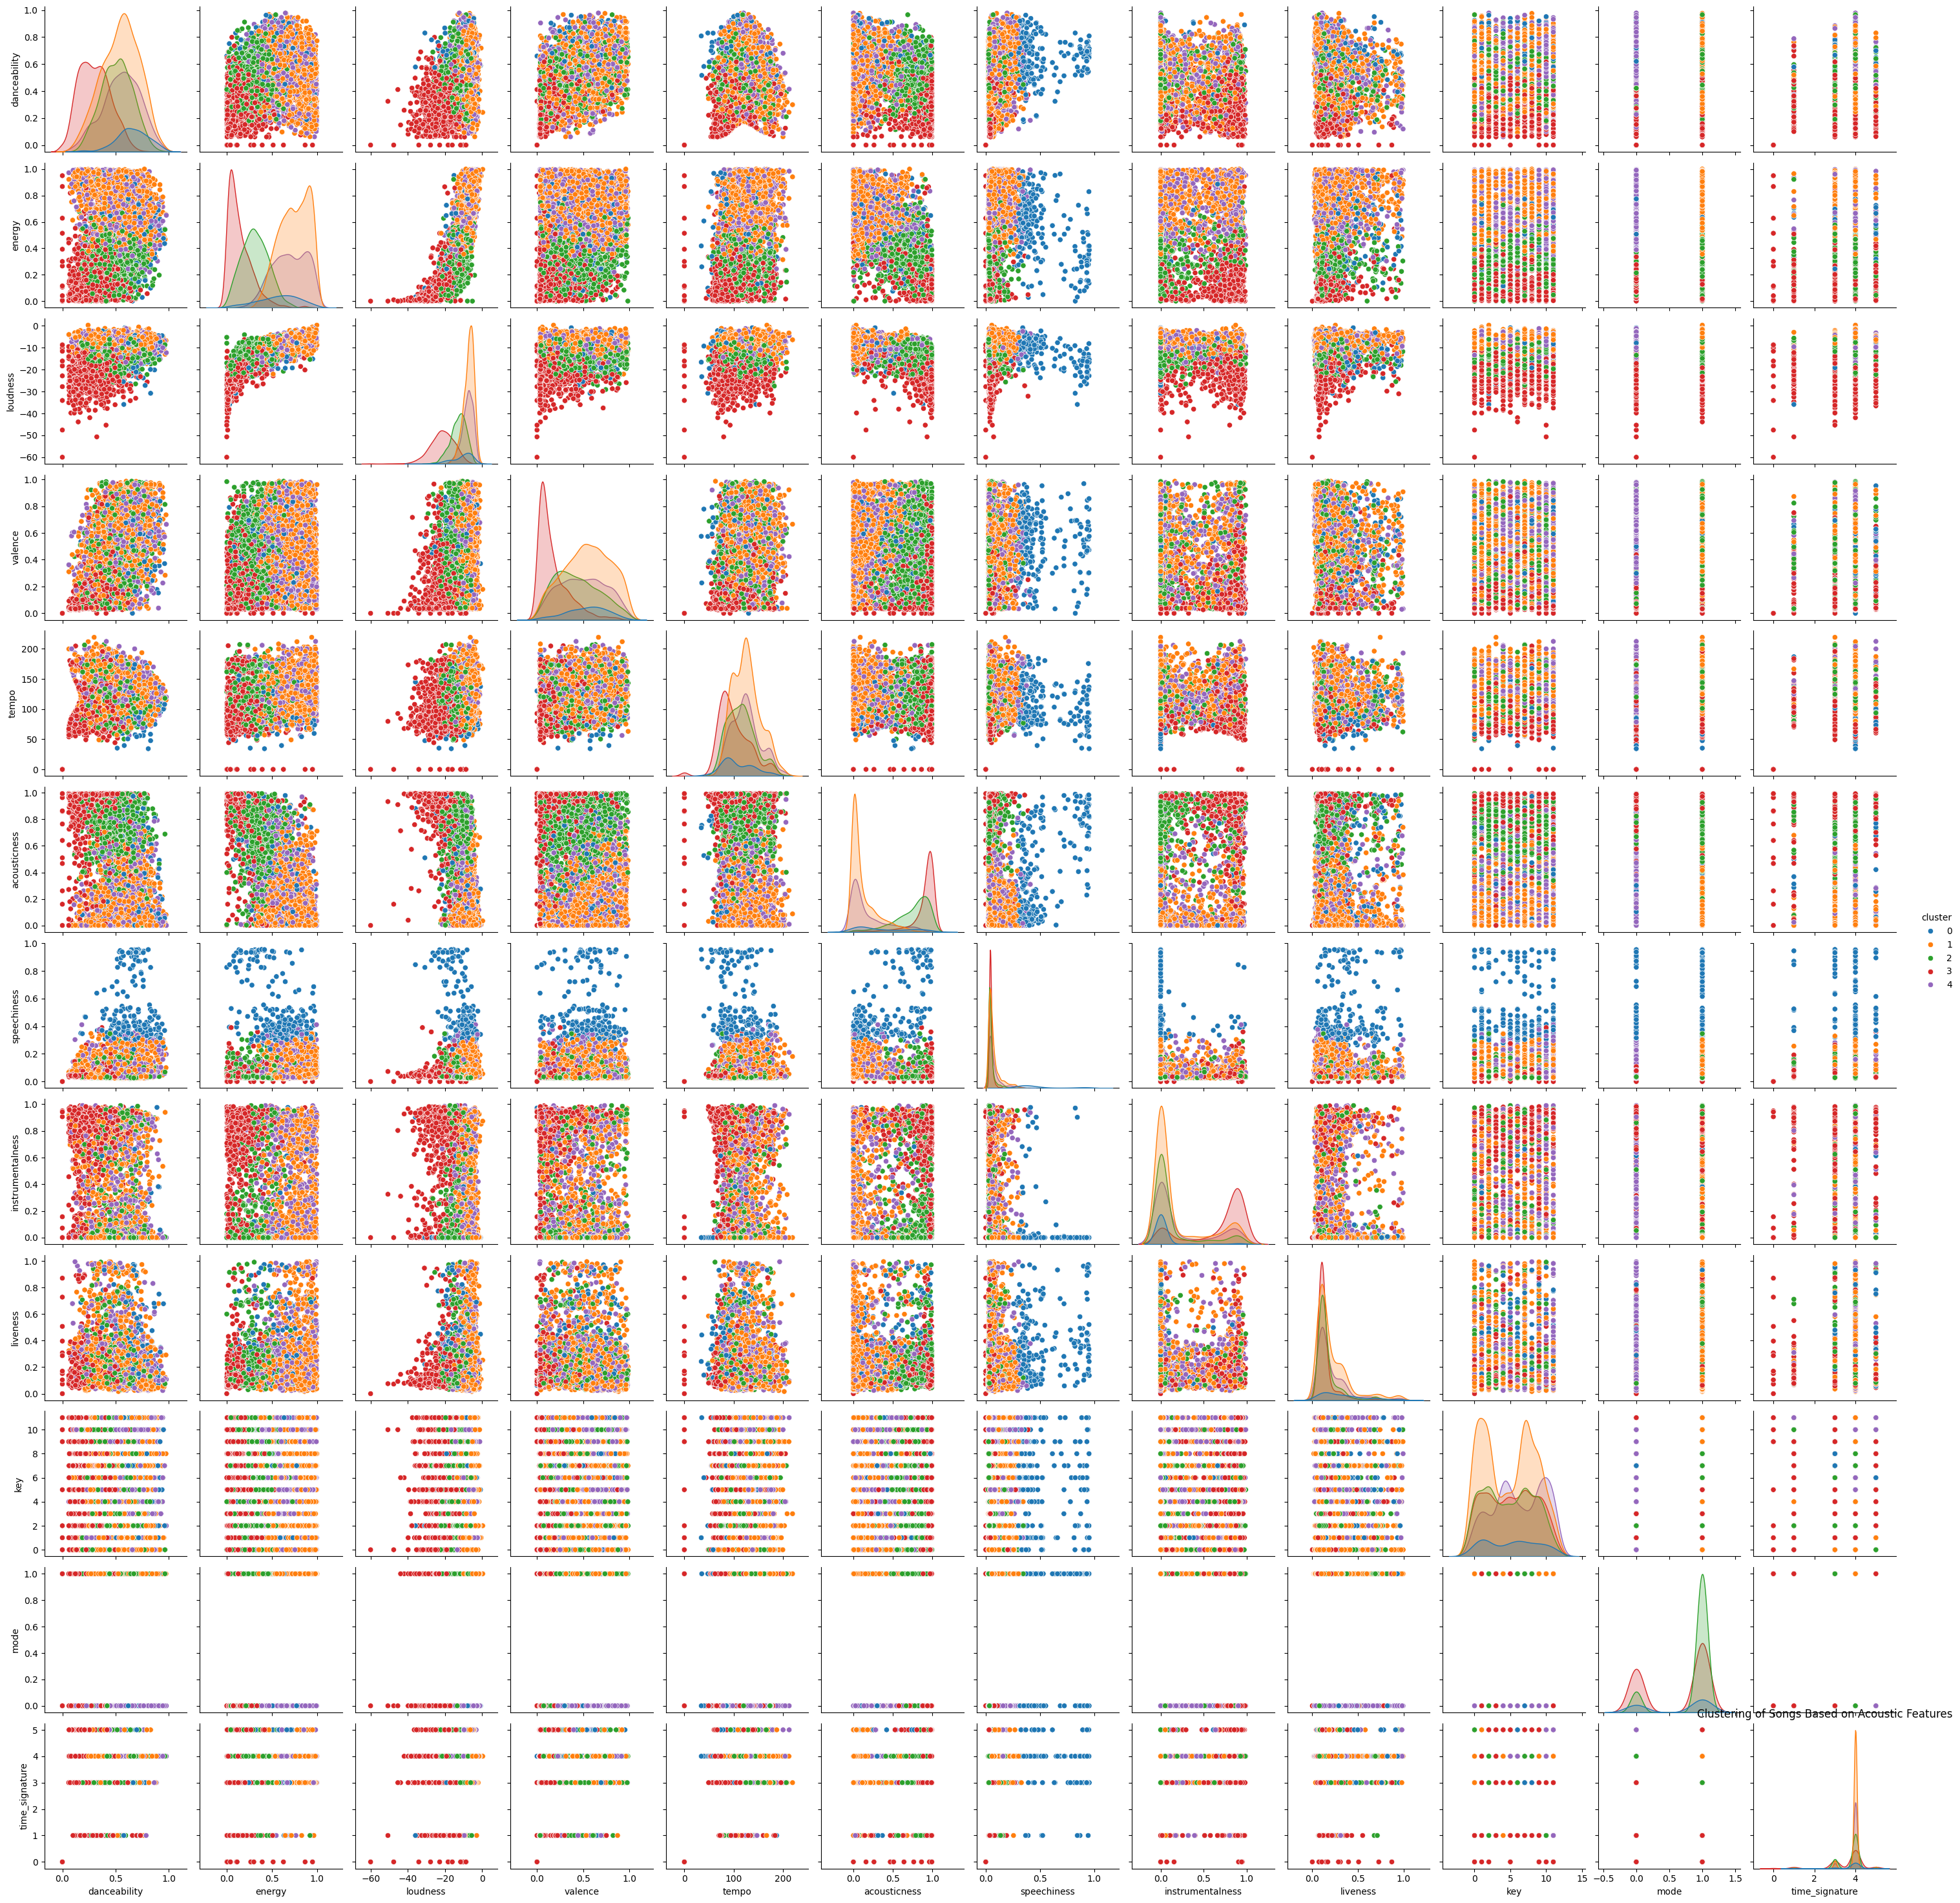

In [13]:
# Clustering Songs
features = [
    'danceability', 'energy', 'loudness', 'valence', 'tempo',
    'acousticness', 'speechiness', 'instrumentalness', 'liveness',
    'key', 'mode', 'time_signature'
]
scaled_data = StandardScaler().fit_transform(songs[features])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
songs['cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters using a pairplot
sns.pairplot(
    songs.sample(5000),  # Sample 5000 rows for better visualization
    vars=features,
    hue='cluster',
    palette='tab10'
)
plt.title("Clustering of Songs Based on Acoustic Features")
plt.show()

In [14]:
# Summarize features for each cluster
cluster_summary = songs.groupby('cluster')[numeric_columns].mean()

# Add song count per cluster
cluster_summary['song_count'] = songs['cluster'].value_counts()

cluster_summary

danceability    energy       key   loudness      mode  speechiness  \
cluster                                                                       
0            0.641402  0.566637  5.288661 -11.086977  0.646867     0.490364   
1            0.537465  0.741070  4.793201  -7.315248  1.000000     0.071240   
2            0.512903  0.314524  4.856759 -12.916301  0.862664     0.049131   
3            0.298949  0.145606  5.071674 -21.847023  0.621865     0.047196   
4            0.558582  0.698246  6.291697  -7.939330  0.000000     0.080451   

         acousticness  instrumentalness  liveness   valence       tempo  \
cluster                                                                   
0            0.402001          0.044780  0.320007  0.531932  111.979531   
1            0.141742          0.195956  0.228255  0.535820  126.483192   
2            0.745624          0.152843  0.175385  0.416158  115.072487   
3            0.877494          0.668615  0.147265  0.172129  101.712599   
4            0.192470          0.233626  0.211273  0.496799  123.545876   

           duration_ms  time_signature  song_count  
cluster                                             
0        200933.690377        3.851380       59918  
1        242319.886189        3.940294      391018  
2        230734.823269        3.809152      258970  
3        283300.604350        3.582613      243786  
4        256130.882000        3.929968      245474

In [15]:
cluster_names = {
    0: "Soft Instrumental Tracks",
    1: "Upbeat Danceable Tracks",
    2: "Balanced Chill Tracks",
    3: "High-Tempo Party Tracks",
    4: "Energetic but Moody Tracks"
}

songs['cluster_name'] = songs['cluster'].map(cluster_names)

In [16]:
songs.head()

name                      album  \
0                Testify  The Battle Of Los Angeles   
1        Guerrilla Radio  The Battle Of Los Angeles   
2       Calm Like a Bomb  The Battle Of Los Angeles   
3              Mic Check  The Battle Of Los Angeles   
4  Sleep Now In the Fire  The Battle Of Los Angeles   

                        artists  track_number  disc_number  explicit  \
0  ['Rage Against The Machine']             1            1     False   
1  ['Rage Against The Machine']             2            1      True   
2  ['Rage Against The Machine']             3            1     False   
3  ['Rage Against The Machine']             4            1      True   
4  ['Rage Against The Machine']             5            1     False   

   danceability  energy  key  loudness  ...  instrumentalness  liveness  \
0         0.470   0.978    7    -5.399  ...          0.000011    0.3560   
1         0.599   0.957   11    -5.764  ...          0.000071    0.1550   
2         0.315   0.970    7    -5.424  ...          0.000002    0.1220   
3         0.440   0.967   11    -5.830  ...          0.000004    0.1210   
4         0.426   0.929    2    -6.729  ...          0.105000    0.0789   

   valence    tempo  duration_ms  time_signature  year  release_date  cluster  \
0    0.503  117.906       210133             4.0  1999    1999-11-02        1   
1    0.489  103.680       206200             4.0  1999    1999-11-02        1   
2    0.370  149.749       298893             4.0  1999    1999-11-02        0   
3    0.574   96.752       213640             4.0  1999    1999-11-02        4   
4    0.539  127.059       205600             4.0  1999    1999-11-02        1   

                 cluster_name  
0     Upbeat Danceable Tracks  
1     Upbeat Danceable Tracks  
2    Soft Instrumental Tracks  
3  Energetic but Moody Tracks  
4     Upbeat Danceable Tracks  

[5 rows x 23 columns]

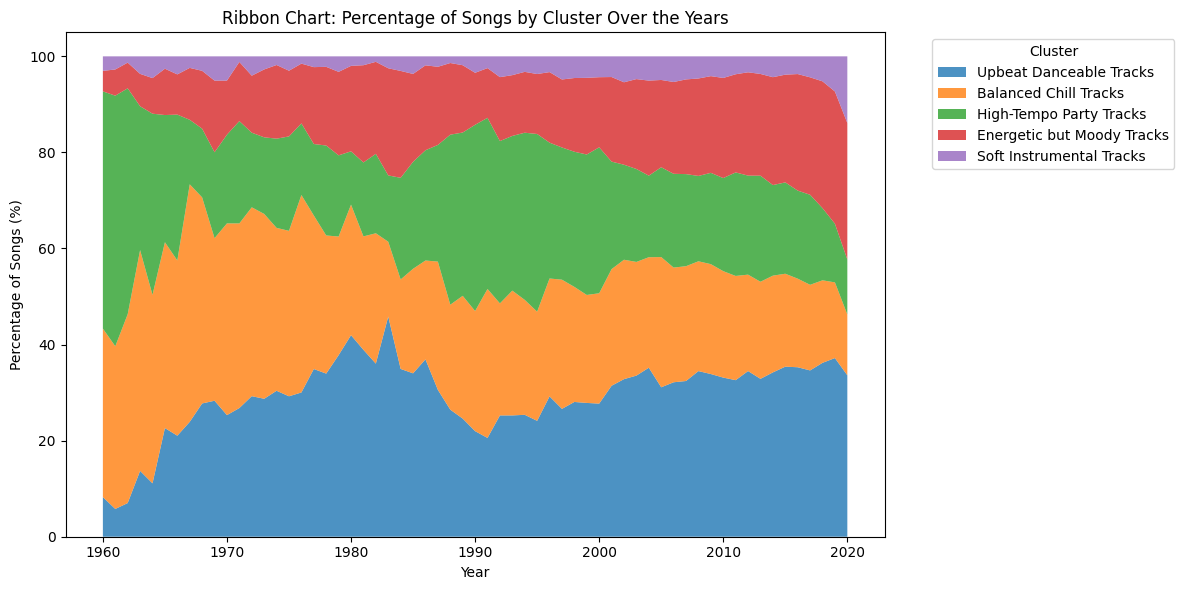

In [17]:
# Group by year and cluster to count the number of songs
cluster_trends = songs.groupby(['year', 'cluster_name']).size().reset_index(name='count')

# Calculate the total number of songs per year
yearly_totals = songs.groupby('year').size().reset_index(name='total_count')

# Merge the two DataFrames to compute percentages
cluster_trends = cluster_trends.merge(yearly_totals, on='year')
cluster_trends['percentage'] = (cluster_trends['count'] / cluster_trends['total_count']) * 100

# Pivot the data to get clusters as columns
ribbon_data = cluster_trends.pivot(index='year', columns='cluster_name', values='percentage').fillna(0)

# Sort clusters by their mean percentage to maintain order in ribbons
ribbon_data = ribbon_data[sorted(ribbon_data.columns, key=lambda col: ribbon_data[col].mean(), reverse=True)]

# Create a ribbon chart (stacked area plot)
plt.figure(figsize=(12, 6))
plt.stackplot(
    ribbon_data.index, 
    ribbon_data.T, 
    labels=ribbon_data.columns, 
    alpha=0.8,
    colors=plt.cm.tab10.colors  # Use a color map for distinct cluster colors
)

plt.title("Ribbon Chart: Percentage of Songs by Cluster Over the Years")
plt.xlabel("Year")
plt.ylabel("Percentage of Songs (%)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

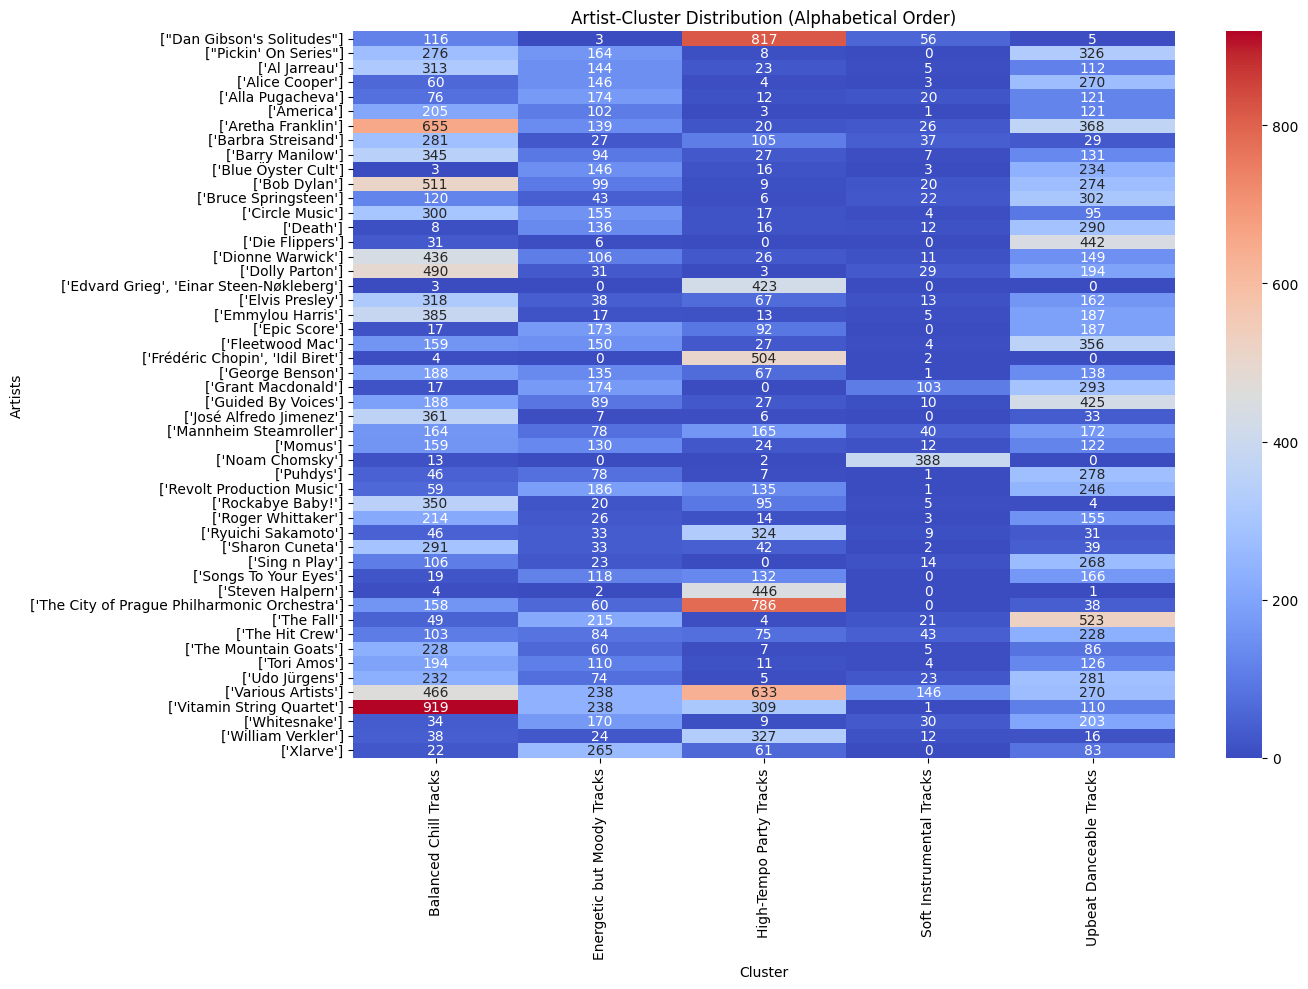

In [18]:
# Pivot the data for a heatmap
artist_cluster_counts = songs.groupby(['artists', 'cluster_name']).size().reset_index(name='count')
artist_cluster_heatmap = artist_cluster_counts.pivot(
    index='artists', columns='cluster_name', values='count'
).fillna(0)

# Filter to most active artists (e.g., at least 10 songs)
active_artists = artist_cluster_heatmap.sum(axis=1).nlargest(50)  # Top 50 active artists
artist_cluster_heatmap = artist_cluster_heatmap.loc[active_artists.index]

# Sort artists alphabetically
artist_cluster_heatmap = artist_cluster_heatmap.sort_index()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    artist_cluster_heatmap, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".0f", 
    cbar=True
)
plt.title("Artist-Cluster Distribution (Alphabetical Order)")
plt.xlabel("Cluster")
plt.ylabel("Artists")
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_artists_per_cluster = artist_cluster_counts.groupby('cluster_name').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


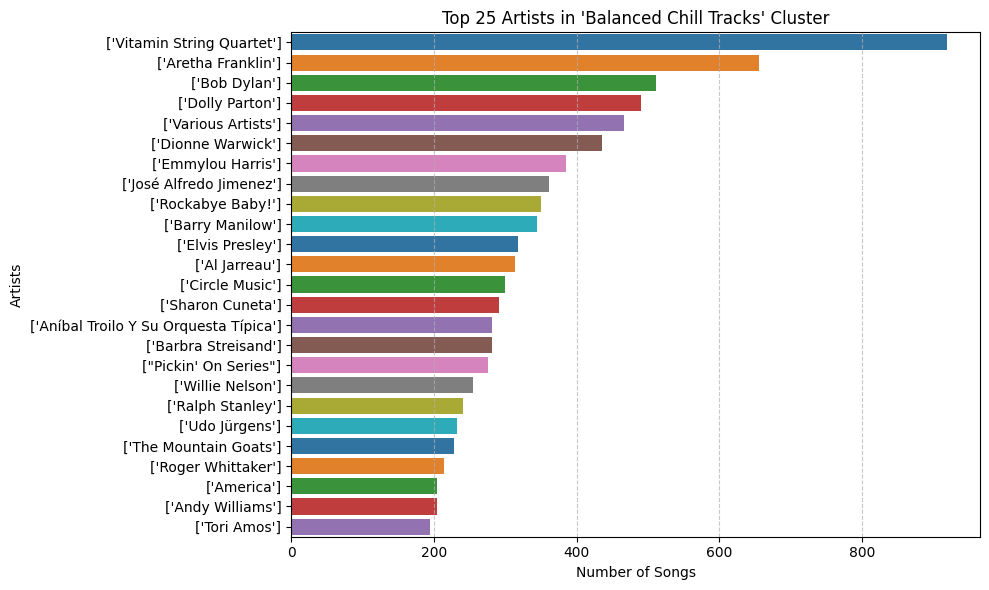

C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


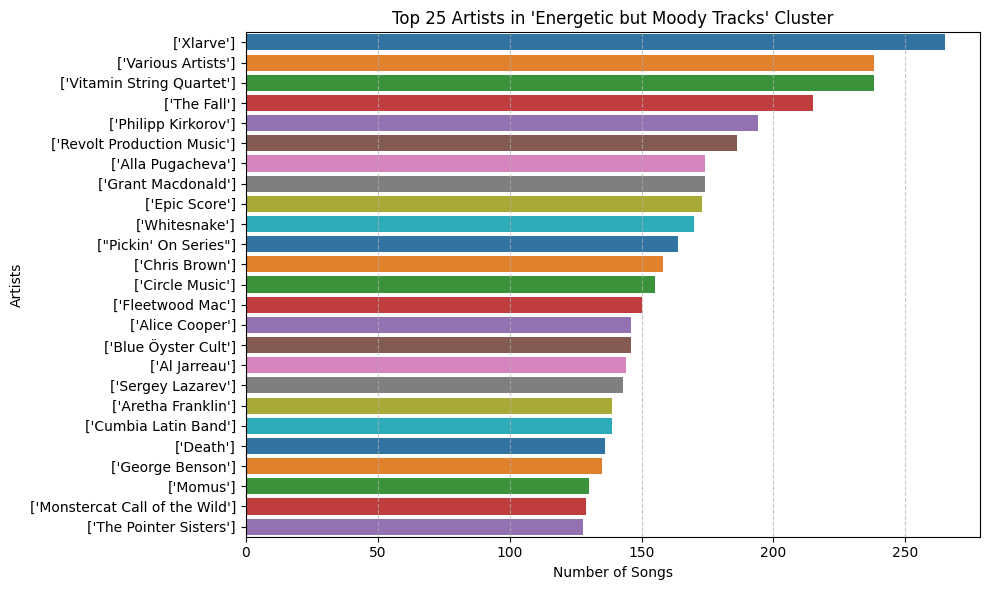

C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


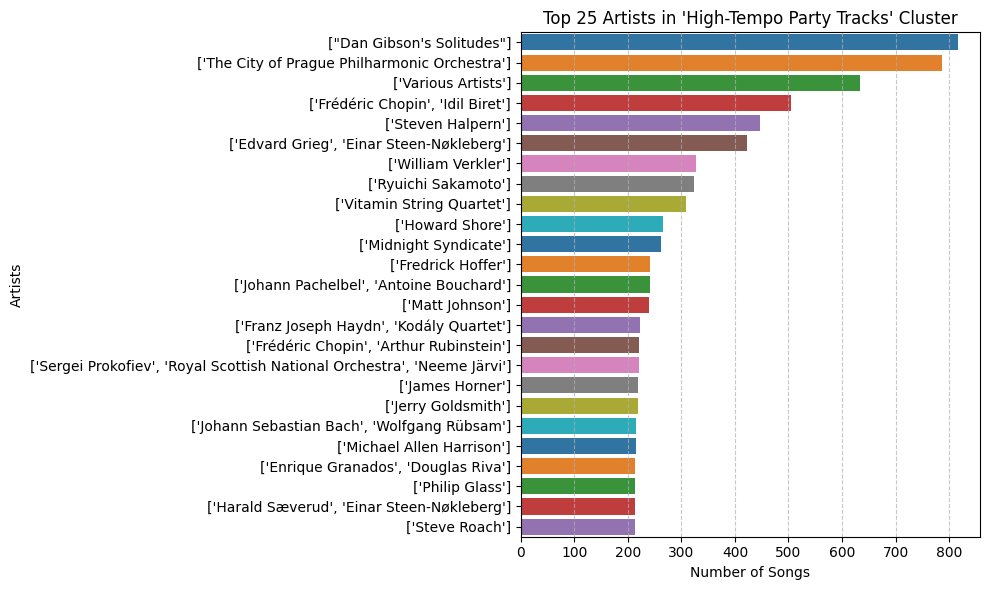

C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


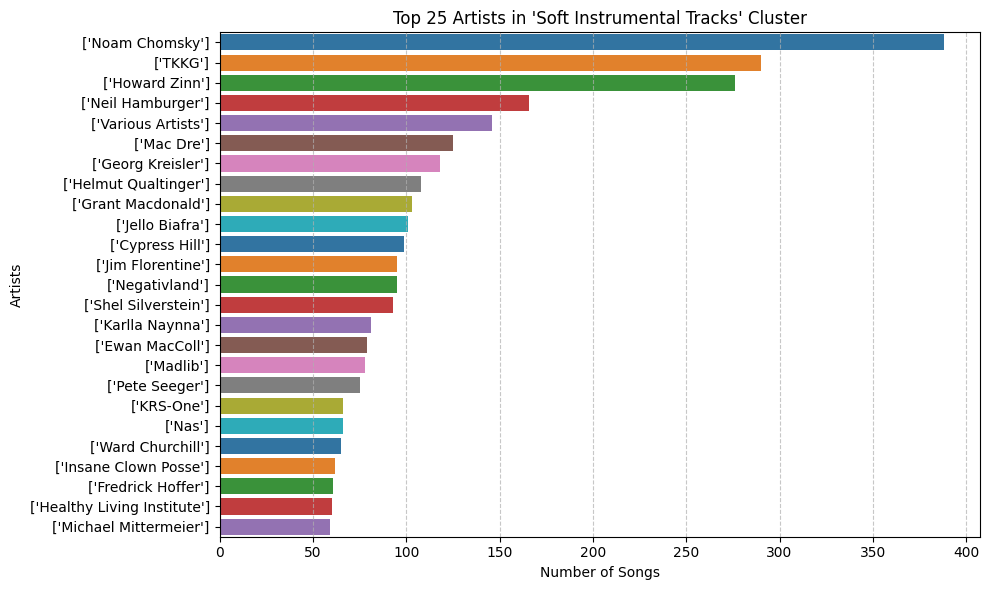

C:\Users\user\AppData\Local\Temp\ipykernel_29396\1888676258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


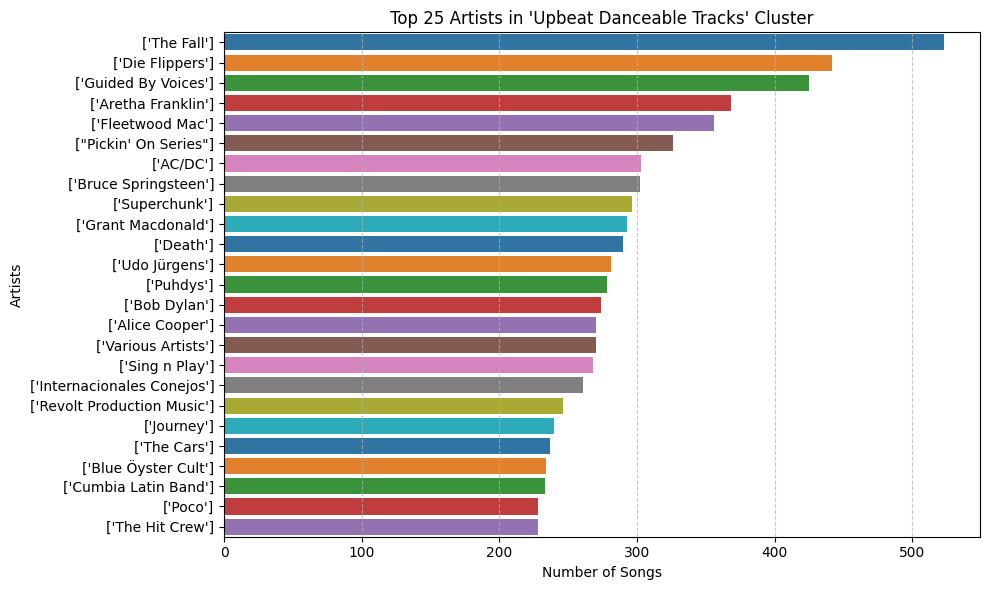

In [19]:
# Get the top artists for each cluster
top_artists_per_cluster = artist_cluster_counts.groupby('cluster_name').apply(
    lambda x: x.nlargest(25, 'count')  # Top 10 artists per cluster
).reset_index(drop=True)

# Plot top artists for each cluster
clusters = top_artists_per_cluster['cluster_name'].unique()

for cluster in clusters:
    cluster_data = top_artists_per_cluster[top_artists_per_cluster['cluster_name'] == cluster]
    
    # Create a bar plot for the current cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=cluster_data, 
        x='count', 
        y='artists', 
        palette="tab10"
    )
    plt.title(f"Top 25 Artists in '{cluster}' Cluster")
    plt.xlabel("Number of Songs")
    plt.ylabel("Artists")
    plt.grid(visible=True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


alculating centroid distances: 100%|██████████████████████████████████████████████████| 61/61 [00:03<00:00, 18.23it/s]

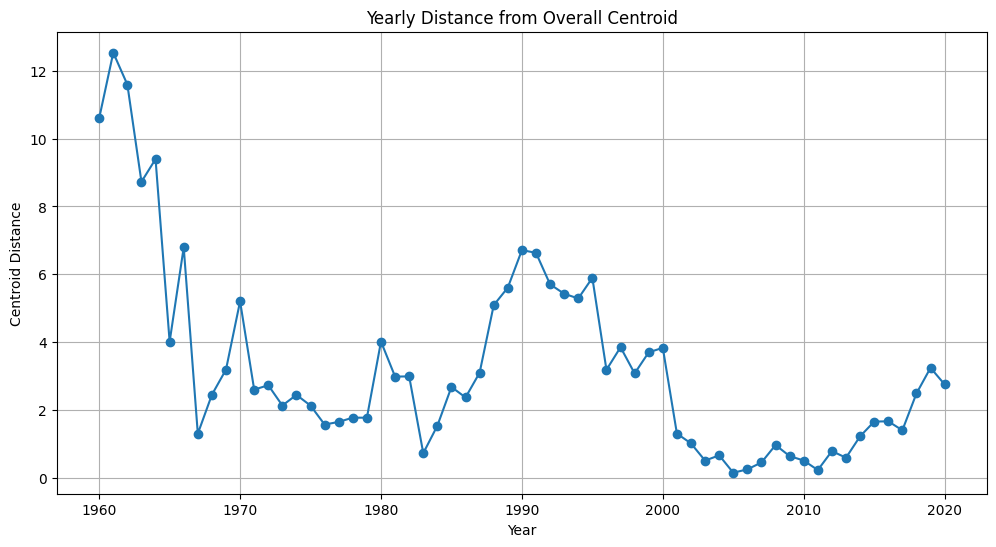

In [20]:
from sklearn.cluster import KMeans

# Use KMeans to cluster songs
years = songs['year'].unique()
n_clusters = 10  # Adjust based on dataset size
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
songs['cluster'] = kmeans.fit_predict(songs[features])

# Compute centroid distances for each year
centroid_distances_per_year = []

for year in tqdm(sorted(years), desc="Calculating centroid distances"):
    year_songs = songs[songs['year'] == year]
    if len(year_songs) > 1:
        year_centroid = year_songs[features].mean(axis=0)
        overall_centroid = songs[features].mean(axis=0)
        distance = np.linalg.norm(year_centroid - overall_centroid)  # Euclidean distance
        centroid_distances_per_year.append({'year': year, 'centroid_distance': distance})

# Convert to DataFrame
centroid_trends = pd.DataFrame(centroid_distances_per_year)

# Plot centroid trends
plt.figure(figsize=(12, 6))
plt.plot(centroid_trends['year'], centroid_trends['centroid_distance'], marker='o')
plt.title("Yearly Distance from Overall Centroid")
plt.xlabel("Year")
plt.ylabel("Centroid Distance")
plt.grid(True)
plt.show()

In [22]:
# Adjust pandas display options
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns (if needed)

# Count songs by year
counts = songs["year"].value_counts().sort_index()  # Sorted by year for proper order

# Convert counts to a DataFrame
counts_df = counts.reset_index()
counts_df.columns = ["Year", "Number of Songs"]

# Display the DataFrame
print(counts_df)

    Year  Number of Songs
0   1960              727
1   1961              623
2   1962              842
3   1963              905
4   1964              729
5   1965              933
6   1966              932
7   1967              916
8   1968              930
9   1969             1247
10  1970             1110
11  1971             1202
12  1972             1938
13  1973             1762
14  1974             1389
15  1975             1806
16  1976             1985
17  1977             1962
18  1978             1923
19  1979             2106
20  1980             2119
21  1981             1897
22  1982             1754
23  1983             1977
24  1984             2571
25  1985             2596
26  1986             2727
27  1987             3314
28  1988             4545
29  1989             5095
30  1990             7453
31  1991             8380
32  1992             9639
33  1993            11017
34  1994            14130
35  1995            17417
36  1996            17840
37  1997    